In [1]:
import os
os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2

## Importing libraries

In [322]:
# data library
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# python
import random
import time
import pathlib

#machine learning library
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder



# baseline line library
from feature_selection.baseline import get_rf_regressor_feature_importance, get_xgboost_regressor_feature_importance
from feature_selection.mrmr import generate_xgboost_score, generate_rf_score

## Reading and cleaning data
The purpose of this exercise is to investigate the effects of feature selection so the data preprocessing will be the main focus

In [288]:
train_df = pd.read_csv("data/housing_price_regression/train.csv")
train_df.head()

train_df = train_df.drop(train_df[train_df['LotFrontage'] > 200].index)
train_df = train_df.drop(train_df[train_df['LotArea'] > 100000].index)
train_df = train_df.drop(train_df[train_df['BsmtFinSF1'] > 4000].index)
train_df = train_df.drop(train_df[train_df['TotalBsmtSF'] > 5000].index)
train_df = train_df.drop(train_df[train_df['GrLivArea'] > 4000].index)


In [289]:
def cal_missing_data(df):
    missing_data = df.isna().sum()
    total_rows = len(train_df)
    columns_to_use = []
    columns_to_drop = []

    for col_name, value in zip(missing_data.index, missing_data.values):
        if value > 0:
            percentage_missing = value/total_rows*100
            if percentage_missing > 7.0:
                columns_to_drop.append(col_name)
                decision = "DROP"
            else:
                columns_to_use.append(col_name)
                decision = "DONT DROP"

            print(f"{col_name}: {value} ({percentage_missing:.4f}%), decision:{decision}")
        else:
            columns_to_use.append(col_name)


    print("\n\nColumns to drop")
    print(columns_to_drop)
cal_missing_data(train_df)

LotFrontage: 256 (17.6430%), decision:DROP
Alley: 1360 (93.7285%), decision:DROP
MasVnrType: 8 (0.5513%), decision:DONT DROP
MasVnrArea: 8 (0.5513%), decision:DONT DROP
BsmtQual: 37 (2.5500%), decision:DONT DROP
BsmtCond: 37 (2.5500%), decision:DONT DROP
BsmtExposure: 38 (2.6189%), decision:DONT DROP
BsmtFinType1: 37 (2.5500%), decision:DONT DROP
BsmtFinType2: 38 (2.6189%), decision:DONT DROP
Electrical: 1 (0.0689%), decision:DONT DROP
FireplaceQu: 690 (47.5534%), decision:DROP
GarageType: 81 (5.5824%), decision:DONT DROP
GarageYrBlt: 81 (5.5824%), decision:DONT DROP
GarageFinish: 81 (5.5824%), decision:DONT DROP
GarageQual: 81 (5.5824%), decision:DONT DROP
GarageCond: 81 (5.5824%), decision:DONT DROP
PoolQC: 1446 (99.6554%), decision:DROP
Fence: 1171 (80.7030%), decision:DROP
MiscFeature: 1399 (96.4163%), decision:DROP


Columns to drop
['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [290]:
def housing_data_cleaning(df, column_to_use):
    """
    This function performs the following stateless function
    1. Drops unused columns and ensure schema is the correct order
    2. Impute na rows 
    3. Drop errornous rows
    """
    # drop columns
    df = df[columns_to_use].copy()
    
    # impute "None"
    columns_to_impute_none = ["MasVnrType", "BsmtQual", "BsmtCond", 
                              "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                              "GarageType","GarageFinish", "GarageQual", "GarageCond"]
    
    df[columns_to_impute_none] = df[columns_to_impute_none].fillna("NA")
    
    #impute 0
    df.loc[df["MasVnrArea"].isna(), "MasVnrArea"] = 0
    
    #impute GarageYrBlt to house built year
    df.loc[df['GarageYrBlt'].isna(), "GarageYrBlt"] = df.loc[df['GarageYrBlt'].isna(), "YearBuilt"]
    
    df = df.dropna()
    return df

In [291]:
cleaned_df = housing_data_cleaning(train_df, columns_to_use)

In [292]:
cal_missing_data(cleaned_df)



Columns to drop
[]


## Encoding of categorical variables

In [293]:
ordinal_encoding_cols = {
    "Street":["Grvl", "Pave"],
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "LandContour": ["Low", "HLS", "Bnk", "Lvl"],
    "Utilities":["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "OverallQual": [1,2,3,4,5,6,7,8,9,10],
    "OverallCond":[1,2,3,4,5,6,7,8,9,10],
    "ExterQual": ["None", "NA","Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["None", "NA","Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual":["None", "NA","Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond":["None","NA","Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["None","NA", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1":["None","NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2":["None","NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC":["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual":["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "Functional": ["NA", "Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish":["NA", "NA", "Unf", "RFn", "Fin"],
    "GarageQual":["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond":["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive":["N","P","Y"]
       
}

one_hot_encoding_cols = [
    "MSSubClass", "MSZoning", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
    "Heating","CentralAir","Electrical", "GarageType", "SaleType", "SaleCondition"
]

In [294]:
# one hot encoding
OHE = OneHotEncoder()
one_hot_encoded_data = OHE.fit_transform(cleaned_df[one_hot_encoding_cols])
encoded_df = pd.DataFrame(one_hot_encoded_data.todense(), columns=list(OHE.get_feature_names_out()))

In [295]:
# ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=list(ordinal_encoding_cols.values()))
ordinal_encoded_data = ordinal_encoder.fit_transform(cleaned_df[list(ordinal_encoding_cols.keys())])
encoded_df[ordinal_encoder.get_feature_names_out()] = ordinal_encoded_data

In [296]:
# convert encoding to float32 to save memory
encoded_df = encoded_df.astype(np.float32)

## Random Forest feature importance

In [264]:
search_dict={
    "n_estimators":{
        "type": "int",
        "low":40,
        "high":150
    }
}
rf_feature_importance_values = get_rf_regressor_feature_importance(encoded_df.to_numpy(), cleaned_df['SalePrice'].values, search_dict, n_trials=10)
rf_feature_importance = encoded_df.columns[np.argsort(rf_feature_importance_values)[::-1]]
print("TOP 20 features")
print(rf_feature_importance[:20])

[I 2022-06-06 23:03:18,844] A new study created in memory with name: no-name-18803aa0-6b73-4a45-abdf-ea26687529d1
[I 2022-06-06 23:03:19,976] Trial 0 finished with value: 0.00018034797239845085 and parameters: {'n_estimators': 77}. Best is trial 0 with value: 0.00018034797239845085.
[I 2022-06-06 23:03:20,913] Trial 1 finished with value: 0.00018077031512514976 and parameters: {'n_estimators': 71}. Best is trial 0 with value: 0.00018034797239845085.
[I 2022-06-06 23:03:21,750] Trial 2 finished with value: 0.0001809098886670258 and parameters: {'n_estimators': 54}. Best is trial 0 with value: 0.00018034797239845085.
[I 2022-06-06 23:03:23,227] Trial 3 finished with value: 0.00017936071797880886 and parameters: {'n_estimators': 109}. Best is trial 3 with value: 0.00017936071797880886.
[I 2022-06-06 23:03:24,146] Trial 4 finished with value: 0.00018105986479806466 and parameters: {'n_estimators': 67}. Best is trial 3 with value: 0.00017936071797880886.
[I 2022-06-06 23:03:25,149] Trial 5 

Best_params
{'n_estimators': 138}
TOP 20 features
Index(['OverallQual', 'GarageFinish', 'MSZoning_RM', 'BsmtFinType1',
       'OverallCond', 'BsmtQual', 'GarageType_Detchd', 'BsmtExposure',
       'KitchenQual', 'MSSubClass_30', 'CentralAir_N', 'CentralAir_Y',
       'LotShape', 'HeatingQC', 'Neighborhood_NoRidge', 'MSSubClass_60',
       'BldgType_1Fam', 'MSZoning_RL', 'GarageCond', 'ExterCond'],
      dtype='object')


## XGBoost

In [250]:
xgboost_search_dict={
    "n_estimators":{
        "type": "int",
        "low":100,
        "high":2000
    },
    "learning_rate":{
        "type": "float",
        "low":0.01,
        "high":0.5
    },
    "max_depth": {
        "type": "int",
        "low":3,
        "high":9
    },
    "min_child_weight": {
        "type": "int",
        "low":1,
        "high":20
    },
    "reg_alpha" :{
        "type": "float",
        "low":0.001,
        "high":0.1
    },
    "reg_lambda":{
        "type":"float",
        "low":0.001,
        "high":0.1
    }
}
xgb_feature_importance_values = get_xgboost_regressor_feature_importance(encoded_df.to_numpy(), cleaned_df['SalePrice'].values, xgboost_search_dict, n_trials=5)
xgb_feature_importance = encoded_df.columns[np.argsort(rf_feature_importance_values)[::-1]]
print("TOP 20 features")
print(xgb_feature_importance[:20])
print("")

[I 2022-06-06 22:52:11,163] A new study created in memory with name: no-name-0d021d38-bf1e-437b-be6d-eeb1ba7abcc1
[I 2022-06-06 22:52:14,720] Trial 0 finished with value: 35159.29937212088 and parameters: {'n_estimators': 327, 'learning_rate': 0.3640017056771902, 'max_depth': 7, 'min_child_weight': 20, 'reg_alpha': 0.0807669267172637, 'reg_lambda': 0.08057645147518658}. Best is trial 0 with value: 35159.29937212088.
[I 2022-06-06 22:52:30,946] Trial 1 finished with value: 34677.01207465284 and parameters: {'n_estimators': 1316, 'learning_rate': 0.23957208003010785, 'max_depth': 6, 'min_child_weight': 18, 'reg_alpha': 0.07675253371050443, 'reg_lambda': 0.033551494795071454}. Best is trial 1 with value: 34677.01207465284.
[I 2022-06-06 22:52:51,500] Trial 2 finished with value: 34266.56669062397 and parameters: {'n_estimators': 1589, 'learning_rate': 0.07604137961674481, 'max_depth': 8, 'min_child_weight': 17, 'reg_alpha': 0.0906042190976301, 'reg_lambda': 0.09849124970529348}. Best is t

Best_params
{'n_estimators': 1589, 'learning_rate': 0.07604137961674481, 'max_depth': 8, 'min_child_weight': 17, 'reg_alpha': 0.0906042190976301, 'reg_lambda': 0.09849124970529348}
TOP 20 features
Index(['OverallQual', 'BsmtExposure', 'BsmtQual', 'GarageFinish',
       'BsmtFinType1', 'KitchenQual', 'Neighborhood_NoRidge', 'ExterQual',
       'MSZoning_RM', 'LotShape', 'GarageType_Detchd', 'OverallCond',
       'MSSubClass_60', 'GarageType_Attchd', 'BldgType_1Fam', 'SaleType_New',
       'BsmtFinType2', 'Neighborhood_Crawfor', 'HeatingQC', 'SaleType_WD'],
      dtype='object')



## MRMR

In [266]:
from sklearn.feature_selection import f_regression

In [269]:
F_score = pd.Series(f_regression(encoded_df, cleaned_df['SalePrice'].values)[0],index =encoded_df.columns)

In [276]:
F_score.sort_values(ascending=False)[:20]

OverallQual             2997.892138
ExterQual               1284.631892
KitchenQual             1178.036967
BsmtQual                 883.870586
GarageFinish             842.469046
Foundation_PConc         589.299697
HeatingQC                430.042803
GarageType_Attchd        300.796876
MSSubClass_60            277.362426
MasVnrType_None          277.190300
GarageType_Detchd        257.117303
GarageQual               223.353894
GarageCond               214.168146
Neighborhood_NridgHt     214.078175
CentralAir_Y             207.099968
CentralAir_N             207.099968
Exterior2nd_VinylSd      202.019778
Exterior1st_VinylSd      200.454388
MSZoning_RM              199.666245
BsmtExposure             198.992050
dtype: float64

In [277]:
corr =encoded_df.corr().abs().clip(0.00001)

In [278]:
corr

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,...,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
MSSubClass_20,1.000000,0.170415,0.040098,0.069645,0.252179,0.385300,0.158397,0.080531,0.154220,0.090162,...,0.028976,0.120446,0.064453,0.014218,0.036439,0.031854,0.059013,0.110137,0.114069,0.149916
MSSubClass_30,0.170415,1.000000,0.011756,0.020419,0.073936,0.112966,0.046440,0.023611,0.045216,0.026435,...,0.099896,0.124523,0.032514,0.094147,0.191184,0.111304,0.225333,0.236020,0.227671,0.208211
MSSubClass_40,0.040098,0.011756,1.000000,0.004805,0.017397,0.026581,0.010927,0.005556,0.010639,0.006220,...,0.019111,0.013379,0.014496,0.035254,0.000549,0.012513,0.012378,0.013859,0.014022,0.011108
MSSubClass_45,0.069645,0.020419,0.004805,1.000000,0.030216,0.046167,0.018979,0.009649,0.018479,0.010803,...,0.038944,0.066602,0.025178,0.045372,0.024007,0.021733,0.098405,0.101935,0.102216,0.065153
MSSubClass_50,0.252179,0.073936,0.017397,0.030216,1.000000,0.167167,0.068722,0.034939,0.066910,0.039118,...,0.149414,0.200532,0.005476,0.087983,0.159313,0.094020,0.237528,0.078751,0.056037,0.159272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Functional,0.031854,0.111304,0.012513,0.021733,0.094020,0.079300,0.007453,0.025130,0.015471,0.007186,...,0.070680,0.116251,0.074324,0.058081,0.106187,1.000000,0.121307,0.080792,0.080698,0.083851
GarageFinish,0.059013,0.225333,0.012378,0.098405,0.237528,0.380093,0.138295,0.084144,0.030075,0.001282,...,0.244699,0.244600,0.002053,0.390637,0.471696,0.121307,1.000000,0.483276,0.482668,0.289190
GarageQual,0.110137,0.236020,0.013859,0.101935,0.078751,0.140262,0.036004,0.017698,0.063094,0.031163,...,0.074626,0.146057,0.054473,0.145413,0.238262,0.080792,0.483276,1.000000,0.959152,0.364640
GarageCond,0.114069,0.227671,0.014022,0.102216,0.056037,0.137107,0.050161,0.045017,0.058845,0.039721,...,0.069738,0.147649,0.049879,0.155307,0.232113,0.080698,0.482668,0.959152,1.000000,0.384902


In [285]:
corr = pd.DataFrame(.00001, index = encoded_df.columns, columns = encoded_df.columns)

# initialize list of selected features and list of excluded features
selected = []
not_selected = encoded_df.columns.to_list()

# repeat K times
for i in range(191):
  
    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        corr.loc[not_selected, last_selected] = encoded_df[not_selected].corrwith(encoded_df[last_selected]).abs().clip(.00001)
        
    # compute FCQ score for all the (currently) excluded features (this is Formula 2)
    score = F_score.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
    # find best feature, add it to selected and remove it from not_selected
    best = score.index[score.argmax()]
    selected.append(best)
    not_selected.remove(best)

In [287]:
selected[:20]

['OverallQual',
 'BldgType_Twnhs',
 'KitchenQual',
 'ExterQual',
 'BsmtQual',
 'GarageFinish',
 'Foundation_PConc',
 'MSSubClass_30',
 'HeatingQC',
 'MSZoning_RL',
 'MSSubClass_60',
 'MasVnrType_None',
 'GarageQual',
 'BsmtExposure',
 'GarageType_Attchd',
 'Neighborhood_NridgHt',
 'CentralAir_Y',
 'SaleType_New',
 'BsmtFinType1',
 'GarageType_Detchd']

## Trying out how the feature importance score changes with increasing features

In [317]:
num_variable = 150

In [318]:
rf_scores = generate_xgboost_score(encoded_df[list(rf_feature_importance[:num_variable])].to_numpy(), cleaned_df['SalePrice'].values,list(rf_feature_importance[:num_variable]))

In [319]:
xgboost_scores = generate_xgboost_score(encoded_df[list(xgb_feature_importance[:num_variable])].to_numpy(), cleaned_df['SalePrice'].values,list(xgb_feature_importance[:num_variable]))

In [320]:
mrmr_scores = generate_xgboost_score(encoded_df[selected[:num_variable]].to_numpy(), cleaned_df['SalePrice'].values,selected[:num_variable])

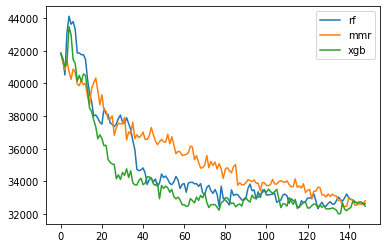

In [321]:
plt.plot(rf_scores, label='rf')
plt.plot(mrmr_scores,label='mmr')
plt.plot(xgboost_scores,label='xgb')
plt.legend()

In [323]:
rf_scores_1 = generate_rf_score(encoded_df[list(rf_feature_importance[:num_variable])].to_numpy(), cleaned_df['SalePrice'].values,list(rf_feature_importance[:num_variable]))

In [324]:
xgboost_scores_1 = generate_rf_score(encoded_df[list(xgb_feature_importance[:num_variable])].to_numpy(), cleaned_df['SalePrice'].values,list(xgb_feature_importance[:num_variable]))

In [325]:
mrmr_scores_1 = generate_rf_score(encoded_df[selected[:num_variable]].to_numpy(), cleaned_df['SalePrice'].values,selected[:num_variable])

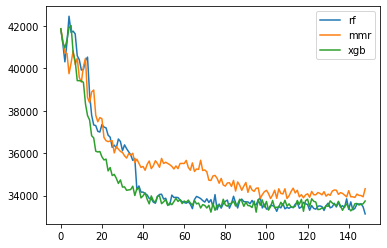

In [326]:
plt.plot(rf_scores_1, label='rf')
plt.plot(mrmr_scores_1,label='mmr')
plt.plot(xgboost_scores_1,label='xgb')
plt.legend()

In [327]:
from sklearn.ensemble import RandomForestRegressor

In [328]:
regressor = RandomForestRegressor()

In [329]:
regressor.fit(encoded_df.to_numpy(), cleaned_df['SalePrice'].values)

RandomForestRegressor()

In [331]:
rf_feature_importance_untuned = encoded_df.columns[np.argsort(regressor.feature_importances_)[::-1]]

In [332]:
rf_feature_importance_untuned

Index(['OverallQual', 'BsmtExposure', 'BsmtQual', 'GarageFinish',
       'KitchenQual', 'BsmtFinType1', 'Neighborhood_NoRidge', 'LotShape',
       'MSZoning_RM', 'GarageType_Detchd',
       ...
       'Heating_Floor', 'Condition2_Artery', 'Exterior2nd_CBlock',
       'Heating_OthW', 'RoofMatl_Roll', 'RoofMatl_Membran',
       'Exterior1st_CBlock', 'Condition2_RRAn', 'Exterior1st_AsphShn',
       'Condition2_PosA'],
      dtype='object', length=191)

In [336]:
xgb_feature_importance

Index(['OverallQual', 'BsmtExposure', 'BsmtQual', 'GarageFinish',
       'BsmtFinType1', 'KitchenQual', 'Neighborhood_NoRidge', 'ExterQual',
       'MSZoning_RM', 'LotShape',
       ...
       'Condition2_RRAn', 'Condition2_PosN', 'Condition2_Artery',
       'Electrical_Mix', 'Exterior1st_AsphShn', 'Condition2_RRNn',
       'Exterior2nd_CBlock', 'Exterior1st_CBlock', 'Exterior1st_ImStucc',
       'RoofMatl_Roll'],
      dtype='object', length=191)

In [334]:
rf_scores_2 = generate_rf_score(encoded_df[list(rf_feature_importance_untuned[:num_variable])].to_numpy(), cleaned_df['SalePrice'].values,list(rf_feature_importance_untuned[:num_variable]))



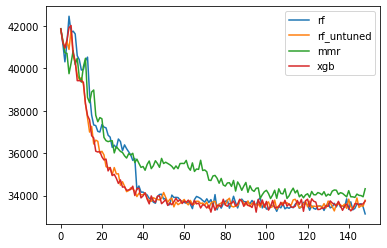

In [335]:
plt.plot(rf_scores_1, label='rf')
plt.plot(rf_scores_2, label='rf_untuned')
plt.plot(mrmr_scores_1,label='mmr')
plt.plot(xgboost_scores_1,label='xgb')
plt.legend()